<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/Notebooks/Regressors/myRegressorsCompare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloner la branche contenant le dataset et le code qui va avec.

In [ ]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 922, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 922 (delta 97), reused 182 (delta 85), pack-reused 717
Receiving objects: 100% (922/922), 128.07 MiB | 39.16 MiB/s, done.
Resolving deltas: 100% (387/387), done.
total 484
drwxr-xr-x 2 root root   4096 Oct 30 08:56 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root   4096 Oct 30 08:56 AllstateClaimsSeverity/
drwxr-xr-x 2 root root   4096 Oct 30 08:56 Data/
drwxr-xr-x 2 root root   4096 Oct 30 08:56 EMTboost/
drwxr-xr-x 2 root root   4096 Oct 30 08:56 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root   4096 Oct 30 08:56 Models/
drwxr-xr-x 2 root root   4096 Oct 30 08:56 Notebooks/
drwxr-xr-x 2 root root   4096 Oct 30 08:56 Plots/
-rw-r--r-- 1 root root     54 Oct 30 08:56 README.md
drwxr-xr-x 2 root root   4096 Oct 30 08:56 src/
-rw-r--r-- 1 root root 454571 Oct 30 08:56 myCatBoostClass

In [ ]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 540 ms, sys: 71.1 ms, total: 611 ms
Wall time: 2min 12s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [ ]:
# Importer les packages nécéssaires
from helper import *

In [ ]:
# Appliquer le theme par défaut
sns.set_theme()

## Partir du dataset déjà encodé.

In [ ]:
# Partir du dataset déja encodé et splité en Train/Test
df_train = pd.read_csv('ActuarialThesis/Data/encodedTrainBASEAUTO.csv')
df_test = pd.read_csv('ActuarialThesis/Data/encodedTestBASEAUTO.csv')
df_train.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR_AUTRE,CAR_BER,CAR_BRK,CAR_CTE,...,SEGM_M2,GARAGE_1,GARAGE_2,GARAGE_3,CSP_1,CSP_50,CSP_55,CSP_60,CSP_AUTRE,CHARGE
0,-0.551995,1,0,2.524444,1,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
1,-1.114303,0,0,0.762290,0,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
2,0.853775,0,1,-1.067640,0,0.732469,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2154.048943
3,-1.114303,0,0,-0.864314,0,-0.817279,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
4,-1.395457,0,0,-1.067640,0,-0.300697,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,772.435649


## Option 2 of the split:

In [ ]:
X_train = df_train.drop('CHARGE', axis=1)
y_train = df_train['CHARGE']

X_test = df_test.drop('CHARGE', axis=1)
y_test = df_test['CHARGE']

# Split the train set into Train/Val sets: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

## CatBoostRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor(n_estimators=1000,silent=True)
parameters = {'n_estimators' : [1000, 2000],
              'loss_function' : ['Tweedie:variance_power=1.1',
                                 'Tweedie:variance_power=1.2',
                                 'Tweedie:variance_power=1.3',
                                 'Tweedie:variance_power=1.4',
                                 'Tweedie:variance_power=1.5',
                                 'Tweedie:variance_power=1.6',
                                 'Tweedie:variance_power=1.7',
                                 'Tweedie:variance_power=1.8',
                                 'Tweedie:variance_power=1.9'
]}

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7d5ade4faa10>,
             n_jobs=-1,
             param_grid={'loss_function': ['Tweedie:variance_power=1.1',
                                           'Tweedie:variance_power=1.2',
                                           'Tweedie:variance_power=1.3',
                                           'Tweedie:variance_power=1.4',
                                           'Tweedie:variance_power=1.5',
                                           'Tweedie:variance_power=1.6',
                                           'Tweedie:variance_power=1.7',
                                           'Tweedie:variance_power=1.8',
                                           'Tweedie:variance_power=1.9'],
                         'n_estimators': [1000, 2000]})

In [ ]:
grid.best_params_

{'loss_function': 'Tweedie:variance_power=1.9', 'n_estimators': 1000}

In [ ]:
from catboost import Pool

train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test, label = y_test)

cb_tweedie = CatBoostRegressor(n_estimators=1000,
                               loss_function='Tweedie:variance_power=1.9',
                               silent=True)
cb_tweedie.fit(train_pool, eval_set=test_pool)

cb_rmse = CatBoostRegressor(n_estimators=1000, loss_function='RMSE', silent=True)
cb_rmse.fit(train_pool, eval_set=test_pool)

In [ ]:
y_pred_rmse_tweedie = np.clip(cb_rmse.predict(test_pool), 0, None)
y_pred_cb_tweedie = cb_tweedie.predict(test_pool)

In [ ]:
# Mean squared logarithmic error (MSLE)
from catboost.utils import eval_metric
from sklearn.metrics import mean_squared_log_error

In [ ]:
print('MSLE score:')
print('\tCatBoost tweedie loss\t', mean_squared_log_error(y_test, y_pred_cb_tweedie))
print('\trmse loss\t', mean_squared_log_error(y_test, y_pred_rmse_tweedie))

MSLE score:
	CatBoost tweedie loss	 17.230723548877105
	rmse loss	 23.381058329296536


In [ ]:
np.log(1766452.642254834), np.log(1758438.3963372826)

(14.384483936621994, 14.379936698344688)

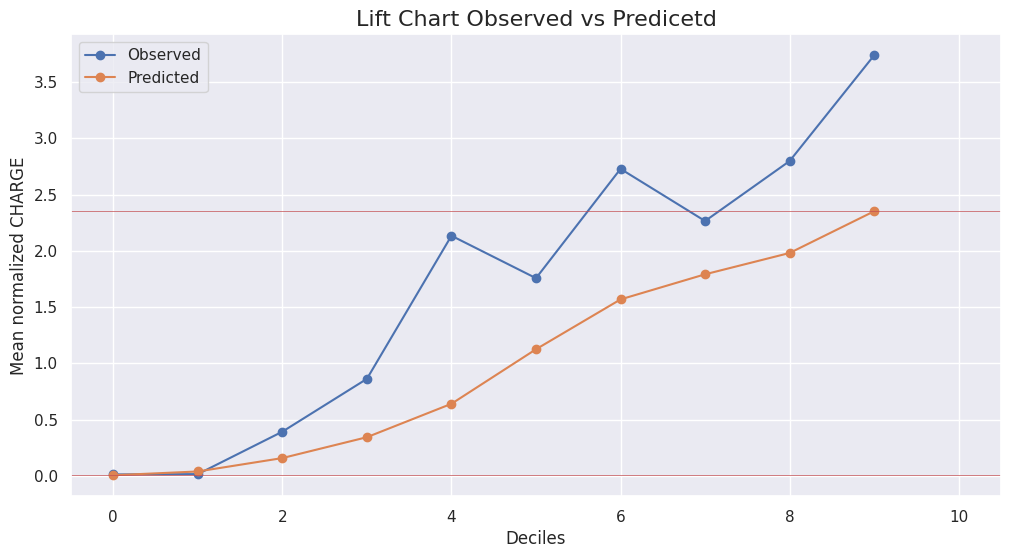

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_cb_tweedie)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

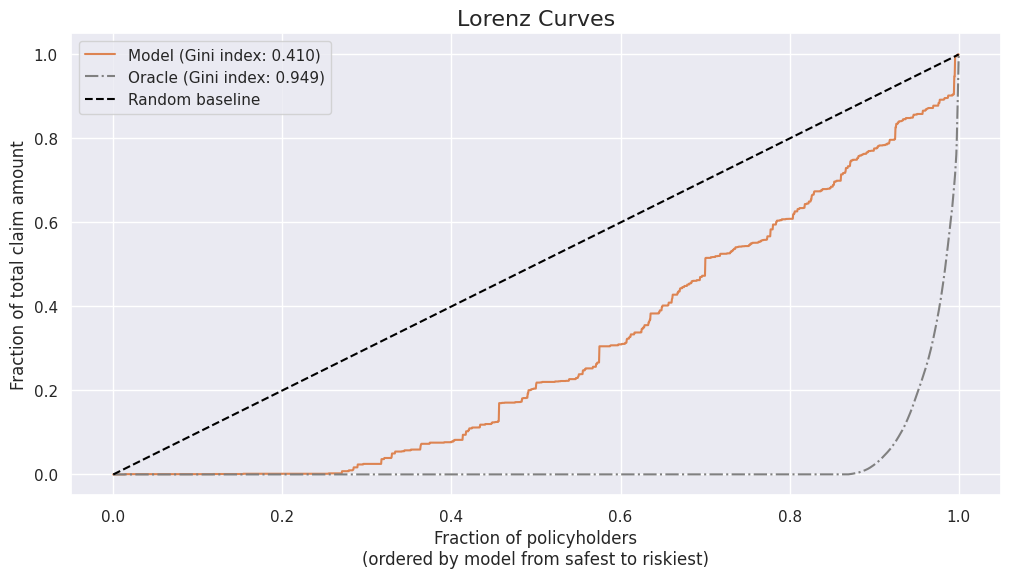

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_cb_tweedie)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')

## XGBRegressor

In [ ]:
model = XGBRegressor(objective='reg:tweedie',
                     max_depth=4,
                     learning_rate=0.042029862461369125,
                     colsample_bytree=0.5711895944308994,
                     subsample=0.5411213855618349,
                     alpha=5.835067732086724,
                           #lambda=6.276955677369005,
                     min_child_weight=695.0944784712658,
                     #tweedie_variance_power=1.2149336293286312,
                     early_stopping_rounds=50,
                     random_state=13
                     )

parameters = {'tweedie_variance_power' : [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]}

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)

GridSearchCV(cv=2,
             estimator=XGBRegressor(alpha=5.835067732086724, base_score=None,
                                    booster=None, callbacks=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.5711895944308994,
                                    device=None, early_stopping_rounds=50,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_c...
                                    learning_rate=0.042029862461369125,
                                    max_bin=None, max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=4, max_leaves=None,
                                    min_child_weight=695.0944784712658,
                                    missing=nan, monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'tweedie_variance_power': [1.1, 1.2, 1.3, 1.4, 1.5,
                                                    1.6, 1.7, 1.8, 1.9]})

In [ ]:
grid.best_params_

{'tweedie_variance_power': 1.5}

In [ ]:
xgb_tweedie = XGBRegressor(objective='reg:tweedie',
                           max_depth=4,
                           learning_rate=0.042029862461369125,
                           colsample_bytree=0.5711895944308994,
                           subsample=0.5411213855618349,
                           alpha=5.835067732086724,
                           #lambda=6.276955677369005,
                           min_child_weight=695.0944784712658,
                           tweedie_variance_power=1.5,
                           early_stopping_rounds=50,
                           random_state=13
                       )
xgb_tweedie.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
y_pred_xgb_tweedie = xgb_tweedie.predict(X_test)

In [ ]:
print('MSLE score:')
print('\tXGBoost tweedie loss\t', mean_squared_log_error(y_test, y_pred_xgb_tweedie))

MSLE score:
	XGBoost tweedie loss	 18.8334288218327


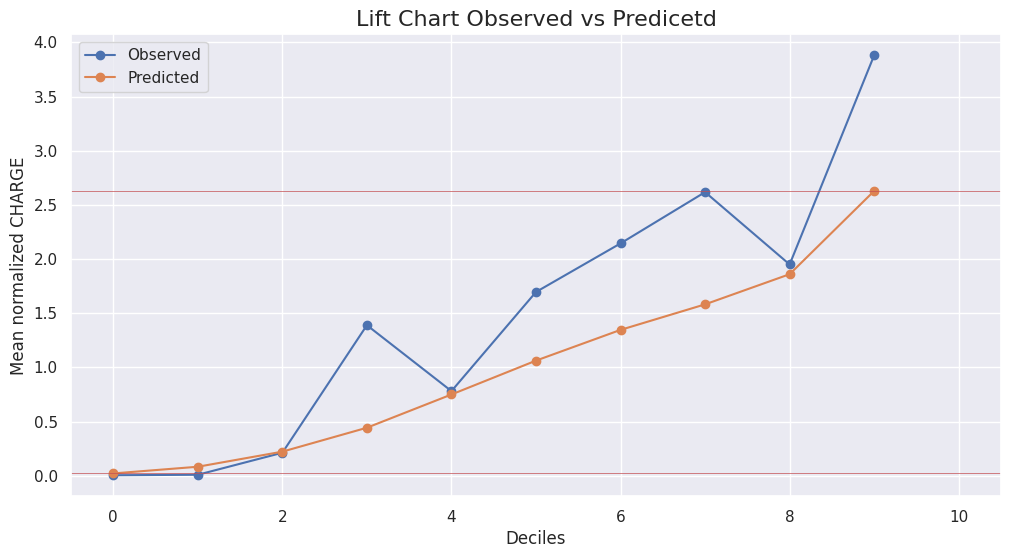

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_tweedie)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myXGBoostRegressorLiftChart.pdf')

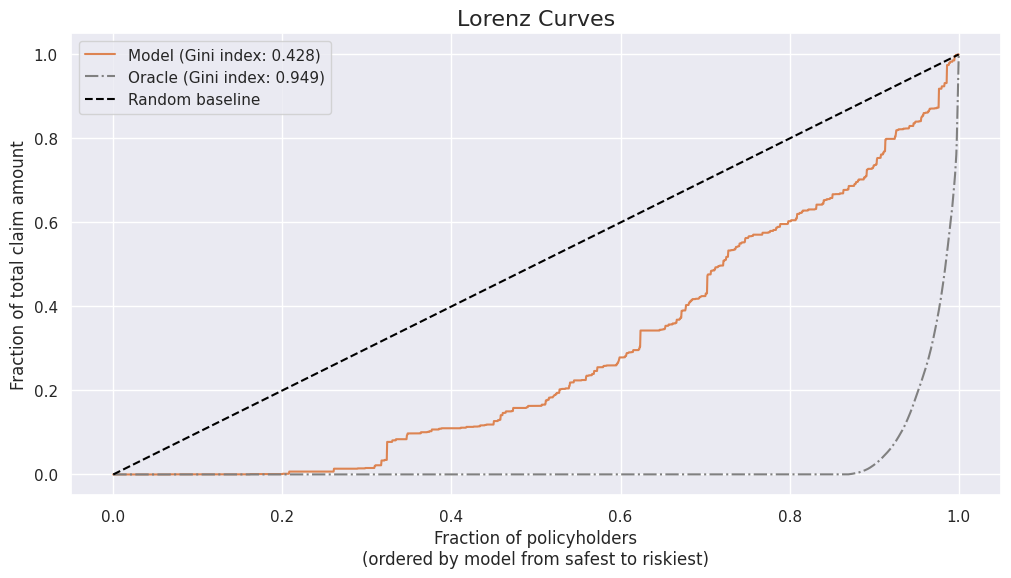

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_tweedie)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myXGBBoostRegressorLorenzCurve.pdf')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
model = LGBMRegressor(objective='tweedie',
                             metric='RMSE',
                             random_state=13,
                             n_estimators=10000,
                             reg_alpha=0.22526419797625372,
                             reg_lambda=0.0005017660037025761,
                             colsample_bytree=0.8789442128781528,
                             subsample=0.6622594582915033,
                             learning_rate=0.18480913197165794,
                             max_depth=4,
                             num_leaves=85,
                             min_child_samples=61,
                             cat_smooth=97,
                             force_col_wise=True,
                             #tweedie_variance_power=1.4301760484836454,
                             verbosity=-1)

parameters = {'tweedie_variance_power' : [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]}

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)

grid.fit(X_train, y_train,
                 eval_set=[(X_val, y_val)],
                 eval_metric='rmse',
                 callbacks=[early_stopping(stopping_rounds=50),
                            log_evaluation(period=20, show_stdv=True),
             ]
        )

Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 1477.74
[40]	valid_0's rmse: 1482.63
[60]	valid_0's rmse: 1485.11
Early stopping, best iteration is:
[14]	valid_0's rmse: 1475.29


GridSearchCV(cv=2,
             estimator=LGBMRegressor(cat_smooth=97,
                                     colsample_bytree=0.8789442128781528,
                                     force_col_wise=True,
                                     learning_rate=0.18480913197165794,
                                     max_depth=4, metric='RMSE',
                                     min_child_samples=61, n_estimators=10000,
                                     num_leaves=85, objective='tweedie',
                                     random_state=13,
                                     reg_alpha=0.22526419797625372,
                                     reg_lambda=0.0005017660037025761,
                                     subsample=0.6622594582915033,
                                     verbosity=-1),
             n_jobs=-1,
             param_grid={'tweedie_variance_power': [1.1, 1.2, 1.3, 1.4, 1.5,
                                                    1.6, 1.7, 1.8, 1.9]})

In [ ]:
grid.best_params_

{'tweedie_variance_power': 1.5}

In [ ]:
lgbm_tweedie = LGBMRegressor(objective='tweedie',
                             metric='RMSE',
                             random_state=13,
                             n_estimators=10000,
                             reg_alpha=0.22526419797625372,
                             reg_lambda=0.0005017660037025761,
                             colsample_bytree=0.8789442128781528,
                             subsample=0.6622594582915033,
                             learning_rate=0.18480913197165794,
                             max_depth=4,
                             num_leaves=85,
                             min_child_samples=61,
                             cat_smooth=97,
                             force_col_wise=True,
                             tweedie_variance_power=1.4301760484836454,
                             verbosity=-1)


lgbm_tweedie.fit(X_train, y_train,
                 eval_set=[(X_val, y_val)],
                 eval_metric='rmse',
                 callbacks=[early_stopping(stopping_rounds=50),
                            log_evaluation(period=20, show_stdv=True),
             ]
        )
y_pred_lgbm_tweedie = lgbm_tweedie.predict(X_test)

Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 1475.29
[40]	valid_0's rmse: 1480.84
[60]	valid_0's rmse: 1480.77
Early stopping, best iteration is:
[19]	valid_0's rmse: 1474.44


In [ ]:
print('MSLE score:')
print('\tXGBoost tweedie loss\t', mean_squared_log_error(y_test, y_pred_lgbm_tweedie))

MSLE score:
	XGBoost tweedie loss	 19.862173628320605


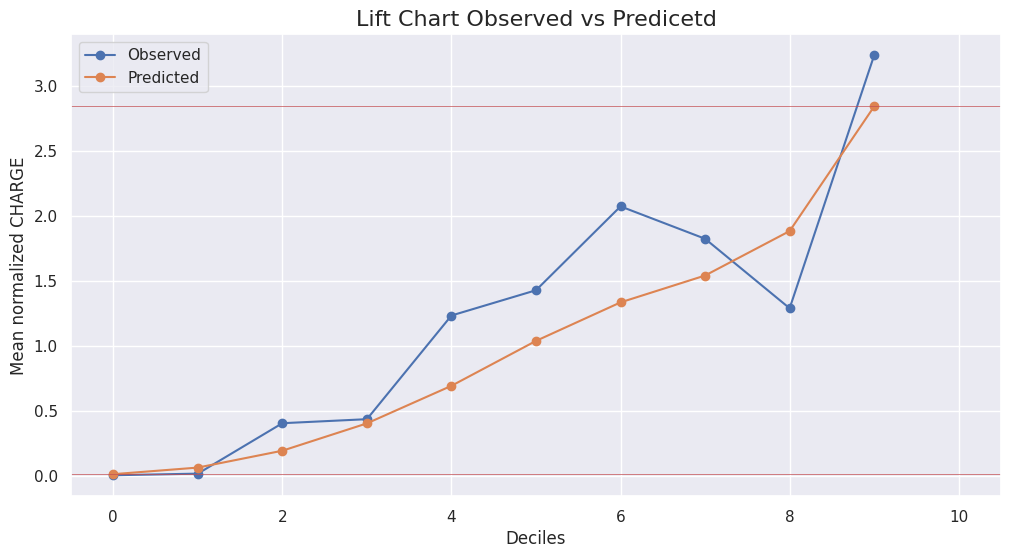

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_tweedie)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorLiftChart.pdf')

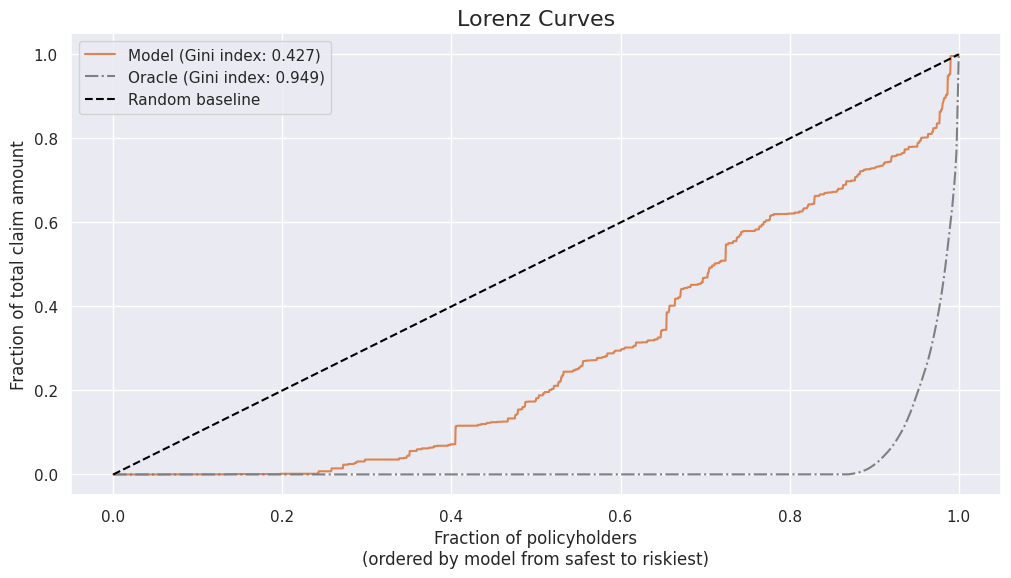

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_tweedie)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorLorenzCurve.pdf')

In [ ]:
np.mean(y_test), np.std(y_test)

(248.89134570311523, 1336.5080972003657)

In [ ]:
np.mean(y_pred_xgb_tweedie), np.std(y_pred_xgb_tweedie)

(169.46613, 141.5761)

In [ ]:
np.mean(y_pred_lgbm_tweedie), np.std(y_pred_lgbm_tweedie)

(208.43367515922566, 190.50681681933193)

In [ ]:
np.mean(y_pred_cb_tweedie), np.std(y_pred_cb_tweedie)

(149.04440640050157, 125.08894413986724)

In [ ]:
0.225*np.mean(y_pred_xgb_tweedie), 0.225*np.mean(y_pred_lgbm_tweedie), 0.225*np.mean(y_pred_cb_tweedie)

(38.129878234863284, 46.89757691082578, 33.534991440112854)

In [ ]:
1.225*np.mean(y_pred_xgb_tweedie), 1.225*np.mean(y_pred_lgbm_tweedie), 1.225*np.mean(y_pred_cb_tweedie)

(207.59600372314455, 255.33125207005145, 182.57939784061443)

In [ ]:
1.225*np.mean(y_pred_xgb_tweedie)+30, 1.225*np.mean(y_pred_lgbm_tweedie) +30, 1.225*np.mean(y_pred_cb_tweedie)+30

(237.59600372314455, 285.33125207005145, 212.57939784061443)

In [ ]:
shap.initjs()

In [ ]:
explainer = TreeExplainer(lgbm_tweedie)
shap_values = explainer.shap_values(X_test)

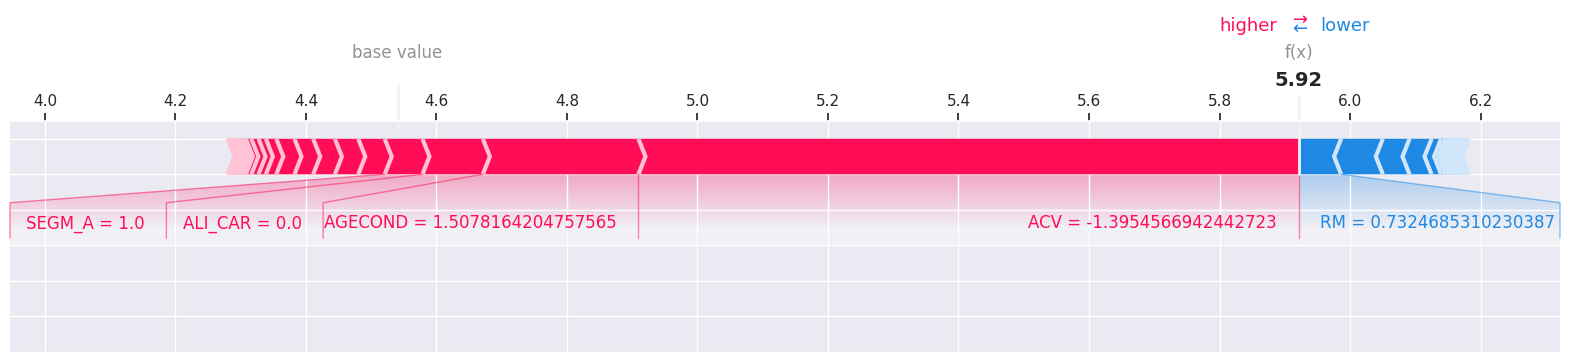

In [ ]:
shap.force_plot(base_value=explainer.expected_value,
                shap_values=shap_values[-1, :],
                features=X_test.iloc[-1, :],
                matplotlib=True)

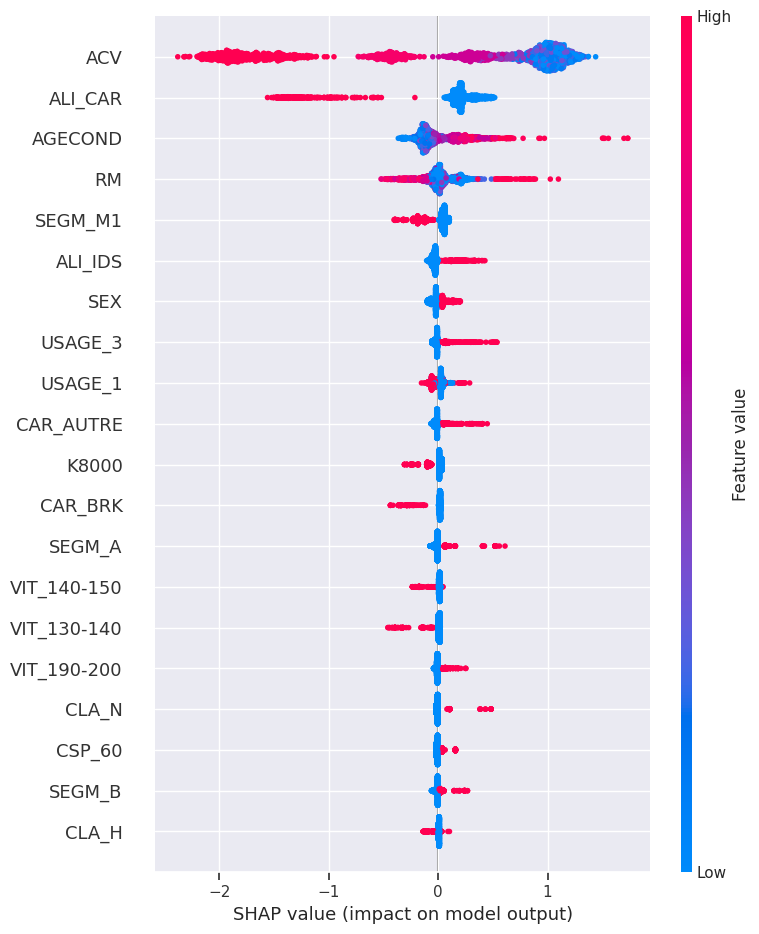

In [ ]:
shap.summary_plot(shap_values,features=X_test)